<a href="https://colab.research.google.com/github/shouvikcirca/PCB_Defect_Detection/blob/master/LeNet5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet5.3_BatchNorm_ReLU

In [1]:
import torch
from torchvision import models, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

/home/shouvik/Desktop/DeepLearning/dl/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shouvik/Desktop/DeepLearning/dl/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shouvik/Desktop/DeepLearning/dl/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shouvik/De

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# For Colab
# X = np.load('drive/My Drive/Copy of xtrain.npy')
# y = np.load('drive/My Drive/Copy of ytrain.npy')

In [44]:
# For local machine
X_train = pickle.load(open(f'X_train298.pkl', 'rb'))
y_train = pickle.load(open(f'y_train298.pkl', 'rb'))
X_test = pickle.load(open(f'X_test298.pkl', 'rb'))
y_test = pickle.load(open(f'y_test298.pkl', 'rb'))

In [46]:
X_test.shape

torch.Size([60, 3, 300, 300])

In [5]:
# For Colab
# X = torch.from_numpy(X)
# X = X.permute(0,3,1,2)
# y = torch.from_numpy(y)
# X.shape, y.shape

Preprocessing Functions

In [6]:
def getNormalized(X,s):
    flattened_channels = X.reshape(3,-1)
    channel_mean = flattened_channels.mean(dim = 1)
    channel_stddev = flattened_channels.std(dim = 1)
    preprocess2 = transforms.Compose([
                      transforms.Normalize(channel_mean, channel_stddev)
    ])


    temptwo = torch.tensor([])
    for i in range(X.shape[0]):
        a = preprocess2(X[i])
        temptwo = torch.cat([temptwo, a.reshape(1,3,s,s)])
  
    return temptwo


def imageSetResize(newSize,X):
    preprocess1 = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize(newSize),
                        transforms.ToTensor()])
  
    temp = torch.tensor([])
    for i in range(X.shape[0]):
        a = preprocess1(X[i])
        temp = torch.cat([temp, a.reshape(1,3,newSize,newSize)])

    return temp 


def splitTrainTest(X,y):
    shuffled_indices = torch.randperm(X.shape[0])
    ul = math.floor(0.8*X.shape[0])
    train_indices = shuffled_indices[:ul]
    test_indices = shuffled_indices[ul:]
    # train_indices.shape[0] + test_indices.shape[0]
    X_train = X[train_indices]
    y_train = y[train_indices]  
    X_test = X[test_indices]
    y_test = y[test_indices]
    print('y_train -> [0]:{} [1]:{}'.format((y_train == 0).sum().item(), (y_train == 1).sum().item()))
    print('y_test -> [0]:{} [1]:{}'.format((y_test == 0).sum().item(), (y_test == 1).sum().item()))
    return X_train, y_train, X_test, y_test


def labelize(p):
    labelized_preds = []
    for i in p:
        l = 0. if i[0]>i[1] else 1.
        labelized_preds.append(l)

    return torch.tensor(labelized_preds)



def shuffle_and_batch(X,y,num,bs):
    shuffled_indices = torch.randperm(X.shape[0])
    newX = X[shuffled_indices]
    newY = y[shuffled_indices]

    X_batches = []
    y_batches = []
    for i in range(num):
        X_batches.append(X[i*bs:(i+1)*bs])
        y_batches.append(y_train[i*bs:(i+1)*bs])

    return X_batches, y_batches

In [7]:
imsize = 32
X_train = imageSetResize(imsize, X_train.float())
X_train = getNormalized(X_train.float(),imsize)
X_test = imageSetResize(imsize, X_test.float())
X_test = getNormalized(X_test.float(),imsize)

Layers

In [8]:
pars = []


#C1
c1 = nn.Conv2d(3,6, kernel_size = 5)
pars = pars + list(c1.parameters())

#S2
pool1 = nn.AvgPool2d(2, stride=2)

# BN1
bn1 = nn.BatchNorm2d(6)
pars = pars + list(bn1.parameters())

#C3
first_cons6_filterlist = []
second_cons6_filterlist = []
third_cons3_filterlist = []
fourth_last1_filterlist = []
for i in range(6):
    first_cons6_filterlist.append(nn.Conv2d(3,1,kernel_size = 5))
    pars = pars + list(first_cons6_filterlist[-1].parameters())
    
for i in range(6):
    second_cons6_filterlist.append(nn.Conv2d(4,1,kernel_size = 5))
    pars = pars + list(second_cons6_filterlist[-1].parameters())
    
for i in range(3):
    third_cons3_filterlist.append(nn.Conv2d(4,1,kernel_size = 5))
    pars = pars + list(third_cons3_filterlist[-1].parameters())

fourth_last1_filterlist = [nn.Conv2d(6,1,kernel_size = 5)]
pars = pars + list(fourth_last1_filterlist[-1].parameters())

#S4
pool2 = nn.AvgPool2d(2, stride=2)


#BN2
bn2 = nn.BatchNorm2d(16)
pars = pars + list(bn2.parameters())


#C5
conv3 = nn.Conv2d(16, 120, kernel_size = 5)
pars = pars + list(conv3.parameters())


#BN3
bn3= nn.BatchNorm2d(120)
pars = pars + list(bn3.parameters())


#F6
ll1 = nn.Linear(120, 84)


#F7
ll2 = nn.Linear(84,2)
pars = pars + list(ll1.parameters()) + list(ll2.parameters())




In [9]:
# Loss Function
criterion = nn.CrossEntropyLoss() 
# criterion = nn.KLDivLoss()

In [10]:
# def displayDetails(lone = None, ltwo=None):
#     if lone is not None:
#         a = lone
#         print('--------')
#         for i in a[0]:
#             print(i)
#         print('--------')
#         for i in a[1]:
#             print(i)
#         print('-------')
#         for i in a[2]:
#             print(i)
#         print('-------')
#         for i in a[3]:
#             print(i)
#     if ltwo is not None:
#         a = ltwo
#         for i in a:
#             print('-----')
#             for j in i:
#                 print(j.shape)

In [11]:
# displayDetails(lone = [first_cons6_filterlist,second_cons6_filterlist,third_cons3_filterlist,fourth_last1_filterlist])

Preprocessing

In [12]:
# resized_imageset = imageSetResize(32, X.float())
# normalized_imageset = getNormalized(resized_imageset.float(),32)

In [13]:
# X_train, y_train, X_test, y_test = splitTrainTest(resized_imageset, y)

In [14]:
# pickle.dump(X_train, open("xtrain298.pkl", 'wb'), protocol=4)
# pickle.dump(X_test, open("xtest298.pkl", 'wb'), protocol=4)
# pickle.dump(y_train, open("ytrain298.pkl", 'wb'), protocol=4)
# pickle.dump(y_test, open("ytest298.pkl", 'wb'), protocol=4)

In [15]:
def ef(li, c1_out):
    return torch.index_select(c1_out, 1, torch.tensor(li))

In [16]:
print('y_train -> [0]:{} [1]:{}'.format((y_train == 0).sum().item(), (y_train == 1).sum().item()))
print('y_test -> [0]:{} [1]:{}'.format((y_test == 0).sum().item(), (y_test == 1).sum().item()))

y_train -> [0]:119 [1]:119
y_test -> [0]:30 [1]:30


In [17]:
def feedForward(X):
    
    global c1
    global first_cons6_filterlist
    global second_cons6_filterlist
    global third_cons3_filterlist
    global fourth_last1_filterlist
    nos = X.shape[0]
    c1_out = c1(X)
    out = F.relu(bn1(pool1(c1_out)))
    lione = [ef([0,1,2],out),ef([1,2,3],out), ef([2,3,4],out), ef([3,4,5],out), ef([0,4,5],out),ef([0,1,5],out)]
    litwo = [ef([0,1,2,3],out),ef([1,2,3,4],out), ef([2,3,4,5],out), ef([0,3,4,5],out), ef([0,1,4,5],out),ef([0,1,2,5],out)]
    lithree = [ef([0,1,3,4],out),ef([1,2,4,5],out), ef([0,2,3,5],out)]
    lifour = [ef([0,1,2,3,4,5],out)]
    feature_maps1 = []
    feature_maps2 = []
    feature_maps3 = []
    feature_maps4 = []
    for i in range(6):
        feature_maps1.append(first_cons6_filterlist[i](lione[i]))
    for i in range(6):
        feature_maps2.append(second_cons6_filterlist[i](litwo[i]))
    for i in range(3):
        feature_maps3.append(third_cons3_filterlist[i](lithree[i]))
    for i in range(1):
        feature_maps4.append(fourth_last1_filterlist[i](lifour[i]))
    fms = []
    fms.extend(feature_maps1)
    fms.extend(feature_maps2)
    fms.extend(feature_maps3)
    fms.extend(feature_maps4)
    tfms = torch.Tensor([])
    for i in fms:
        tfms = torch.cat([tfms, i], dim=1)
    c2_out = F.relu(bn2(pool2(tfms)))
    c3_out = bn3(conv3(c2_out))
    c3_out = c3_out.reshape(nos,120)
    ll1_out = F.relu(ll1(c3_out))
    ll2_out = ll2(ll1_out)
#     preds = nn.Softmax(dim=1)(ll2_out)
    preds = F.log_softmax(ll2_out, dim=1)
    
    return preds

In [18]:
def labelToOneHot(x):
    t = torch.zeros(x.shape[0],2).float()
    for i in range(x.shape[0]):
        if x[i] == 0.:
            t[i][0] = 1
        else:
            t[i][1] = 1
            
    return t

In [19]:
optimizer = optim.Adam(pars,lr=1e-3) # Optimizer
# tb = SummaryWriter()

for epoch in range(25):
    print('Epoch {}'.format(epoch))
    X_batches, y_batches = shuffle_and_batch(X_train, y_train, 4, 67)
    for i in range(len(X_batches)):
        preds = feedForward(X_batches[i])
#         loss = criterion(preds,labelToOneHot(y_batches[i])) 
        loss = criterion(preds,y_batches[i].long())+ 0.65*sum(p.pow(2.0).sum() for p in pars)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
    
    
    
    # Checking model on training set
    train_preds = feedForward(X_train)
    train_loss = criterion(train_preds, y_train.long())
#     train_loss = criterion(train_preds,labelToOneHot(y_train))
    train_preds = labelize(train_preds)
    train_prediction_comparisons = (y_train == train_preds)
    train_accuracy = float(train_prediction_comparisons.sum())/float(y_train.shape[0])
    print('TrainLoss:{} TrainAccuracy:{}'.format(train_loss.item(), train_accuracy), end='  ')
    

    # Checking model on testing set
    test_preds = feedForward(X_test)
    test_loss = criterion(test_preds, y_test.long())
#     test_loss = criterion(test_preds,labelToOneHot(y_test))
    test_preds = labelize(test_preds)
    test_prediction_comparisons = (y_test == test_preds)
    test_accuracy = float(test_prediction_comparisons.sum())/float(y_test.shape[0])
    print('TestLoss:{} TestAccuracy:{}'.format(test_loss.item(), test_accuracy))
    
#     tb.add_scalar('TrainLoss',train_loss, epoch)
#     tb.add_scalar('TestLoss',test_loss, epoch)
#     tb.add_scalar('TrainAccuracy', train_accuracy, epoch)
#     tb.add_scalar('TestAccuracy', test_accuracy, epoch)

Epoch 0
TrainLoss:0.6626825332641602 TrainAccuracy:0.6512605042016807  TestLoss:0.6604188680648804 TestAccuracy:0.6666666666666666
Epoch 1
TrainLoss:0.6277774572372437 TrainAccuracy:0.726890756302521  TestLoss:0.6447160840034485 TestAccuracy:0.6666666666666666
Epoch 2
TrainLoss:0.6078929305076599 TrainAccuracy:0.7941176470588235  TestLoss:0.6386173367500305 TestAccuracy:0.65
Epoch 3
TrainLoss:0.590805172920227 TrainAccuracy:0.8319327731092437  TestLoss:0.6318234205245972 TestAccuracy:0.6666666666666666
Epoch 4
TrainLoss:0.5726038217544556 TrainAccuracy:0.8487394957983193  TestLoss:0.6227000951766968 TestAccuracy:0.6666666666666666
Epoch 5
TrainLoss:0.5555788278579712 TrainAccuracy:0.8529411764705882  TestLoss:0.6150354146957397 TestAccuracy:0.7
Epoch 6
TrainLoss:0.5392376184463501 TrainAccuracy:0.8739495798319328  TestLoss:0.6081900000572205 TestAccuracy:0.7333333333333333
Epoch 7
TrainLoss:0.523076593875885 TrainAccuracy:0.8991596638655462  TestLoss:0.6020727753639221 TestAccuracy:0.7

Confusion Matrix

In [20]:
def cmatrix(target,preds):

    di = {}
    
    count00 = 0
    for i,j in zip(target,preds):
        if i==0.0 and j==0.0:
            count00+=1
    di['count00'] = count00
        
    
    count11 = 0
    for i,j in zip(target,preds):
        if i==1. and j==1.:
            count11+=1
    di['count11'] = count11

    
    count01 = 0
    for i,j in zip(target,preds):
        if i==0. and j==1.:
            count01+=1
    di['count01'] = count01
    
    count10 = 0
    for i,j in zip(target,preds):
        if i==1. and j==0.:
            count10+=1
    di['count10'] = count10
        
    print(di)

In [21]:
confusion_matrix(y_train, train_preds)

array([[119,   0],
       [  9, 110]])

In [22]:
confusion_matrix(y_test, test_preds)


array([[24,  6],
       [ 9, 21]])

AugSet

In [23]:
Xaug = pickle.load(open(f'X5040.pkl', 'rb'))
yaug = pickle.load(open(f'y5040.pkl', 'rb'))

In [24]:
aug_preds = feedForward(Xaug)
# aug_loss = criterion(aug_preds, labelToOneHot(yaug))
aug_preds = labelize(aug_preds)
aug_prediction_comparisons = (yaug == aug_preds)
aug_accuracy = float(aug_prediction_comparisons.sum())/float(yaug.shape[0])
print('AugAccuracy:{}'.format(aug_accuracy), end='  ')  

AugAccuracy:0.5240079365079365  

In [25]:
confusion_matrix(yaug, aug_preds)

array([[1576,  944],
       [1455, 1065]])

In [26]:
f1_score(yaug, aug_preds, average = 'weighted')

0.5190640560189804

Raw

In [27]:
Xraw = pickle.load(open(f'X5040_32_raw.pkl', 'rb'))
yraw = pickle.load(open(f'y5040_32_raw.pkl', 'rb'))

In [28]:
raw_preds = feedForward(Xraw)
# raw_loss = criterion(raw_preds, labelToOneHot(yraw))
raw_preds = labelize(raw_preds)
raw_prediction_comparisons = (yraw == raw_preds)
raw_accuracy = float(raw_prediction_comparisons.sum())/float(yraw.shape[0])
print('RawAccuracy:{}'.format(raw_accuracy), end='  ')  

RawAccuracy:0.6545522667665793  

In [29]:
confusion_matrix(yraw, raw_preds) #target on the vertical axis and preds on the horizontal

array([[ 148,    1],
       [ 921, 1599]])

In [30]:
f1_score(yraw, raw_preds, average = 'weighted')

0.7464475208134725

In [31]:
# a = torch.Tensor([[1,2,3]])
# b = nn.Linear(3,2)
# c = nn.Dropout(p=0.4)

In [32]:
a = pickle.load(open(f'X298.pkl', 'rb'))
b = pickle.load(open(f'y298.pkl', 'rb'))
a.shape, b.shape

(torch.Size([298, 3, 300, 300]), torch.Size([298]))

In [33]:
onezeroes = []
for i in range(Xraw.shape[0]):
    if yraw[i] == 1. and raw_preds[i] == 0.:
        onezeroes.append(i)

onezeroes = torch.Tensor(onezeroes).long()

In [34]:
onezeroimages = Xraw[onezeroes]

In [35]:
Xraw.shape

torch.Size([2669, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


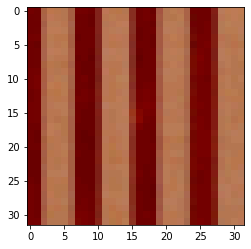

In [36]:
plt.imshow(onezeroimages[5].permute(1,2,0))

In [37]:
# import torchvision
# tb = SummaryWriter()
# grid = torchvision.utils.make_grid(onezeroimages[:10])
# tb.add_image('ims',grid)
# tb.close()